## Association Analysis

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt 
import folium
import os
import datetime as dt


from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium

import networkx as nx
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan
# see the folders available
import gower
import math
from sklearn.cluster import DBSCAN
import time

#os.listdir(os.getcwd())

In [2]:
c_co_in=pd.read_csv('association_c_co_in.csv', sep=',', index_col=0,low_memory=False)
c_co_out=pd.read_csv('association_c_co_out.csv', sep=',', index_col=0,low_memory=False)
c_co_out['OwnerSince']=pd.to_datetime(c_co_out['OwnerSince'], utc=True) 
c_co_out['OwnerTill']=pd.to_datetime(c_co_out['OwnerTill'], utc=True) 

In [3]:
a=pd.to_datetime('01JAN19:00:00:00',format='%d%b%y:%H:%M:%S', utc=False)
c_co_out['seconds']=(c_co_out['OwnerSince'].dt.tz_localize(None)-pd.to_datetime(a)).dt.total_seconds()/10 #miliseconds eliminated
c_co_out['seconds_2']=c_co_out['seconds']
c_co_out[c_co_out.columns[[1,3,-2,-1]]].head(2)

,NextOwnerId,OwnerSince,seconds_2,trans_id_2
1,d9d8a373-29f0-4fe5-8f17-39669083ac48,2019-09-23 07:29:08.691234+00:00,2.292295e+06,NaN
3,cb1f92f7-ffbb-43a6-b741-b1d71cb2a157,2019-09-23 07:29:29.218375+00:00,2.292297e+06,NaN


In [4]:
# measure execution time

start_time = time.time()


#slice df
df=c_co_out.tail(100)
dist_matrix = gower.gower_matrix(df[['seconds','NextOwnerId']])



db = DBSCAN(eps = 0.01, min_samples = 2, metric = "precomputed").fit(dist_matrix)
print("--- %s seconds ---" % (time.time() - start_time))

labels = db.labels_
print("--- %s seconds ---" % (time.time() - start_time))

df['cluster']=labels
df[df['cluster']>=0][['NextOwnerId','OwnerSince','seconds','cluster']].sort_values(by='cluster').head()

--- 0.017519712448120117 seconds ---
--- 0.01787590980529785 seconds ---


/var/folders/bs/8_rscwxd25z1bcq4d89vsz380000gn/T/ipykernel_3730/1575124896.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster']=labels


,NextOwnerId,OwnerSince,seconds,cluster
496154,0a8ac91d-7bab-44cb-9397-542658c440ee,2022-03-04 11:23:39.679564+00:00,1.000922e+07,0
496242,0a8ac91d-7bab-44cb-9397-542658c440ee,2022-03-04 11:27:03.340170+00:00,1.000924e+07,0
496169,58603946-2314-4f85-ba1f-bb9654cede7b,2022-03-04 11:24:24.811124+00:00,1.000923e+07,1
496170,58603946-2314-4f85-ba1f-bb9654cede7b,2022-03-04 11:24:24.811124+00:00,1.000923e+07,1
496171,3aa2f417-1563-45e7-ab51-ba88b54cf41d,2022-03-04 11:24:24.811124+00:00,1.000923e+07,2


In [5]:
# dbscan date by date
#dic=dict()
c_co_out['trans_id_2']=pd.Series()
start_time = time.time()
for date in c_co_out['OwnerSince'].dt.date.unique():
    df=c_co_out[c_co_out['OwnerSince'].dt.date==date].copy()
    dist_matrix = gower.gower_matrix(df[['seconds','NextOwnerId']])
    db = DBSCAN(eps = 0.01, min_samples = 2, metric = "precomputed").fit(dist_matrix)
    #dic[date]=db.labels_
    labels = db.labels_


    df['cluster']=labels
    df['trans_id_2']=(str(date)+'_'+df[df['cluster']>-1]['cluster'].astype(str)  )
    x=df[df['cluster']>-1]
    #print(id_, x.shape)
    c_co_out.update(x['trans_id_2'])
    
    
print("--- %s seconds ---" % (time.time() - start_time))
c_co_out.to_csv('association_c_co_out.csv')

/var/folders/bs/8_rscwxd25z1bcq4d89vsz380000gn/T/ipykernel_3730/3236016744.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  c_co_out['trans_id_2']=pd.Series()


--- 577.5808188915253 seconds ---


In [6]:
# loop over users
# However, it takes too much time.
len(set(list(c_co_out['NextOwnerId'])))

19848

In [7]:
c_co_out[c_co_out['trans_id_2'].isna()==False].shape

(82800, 20)

In [8]:
c_co_out.shape

(281719, 20)

In [9]:
c_co_out['OwnerSince'].dtype

datetime64[ns, UTC]

In [10]:
c_co_out.columns

Index(['OwnerId', 'NextOwnerId', 'ContainerId', 'OwnerSince', 'OwnerTill',
       'IsBillableTransaction', 'TransactionId', 'container_type_id',
       'owner_store_id', 'next_owner_store_id', 'owner_co_int_',
       'next_owner_co_int_', 'owner_claim_type', 'next_owner_claim_type',
       'geometry', 'Source', 'Target', 'seconds', 'seconds_2', 'trans_id_2'],
      dtype='object')

In [11]:
c_co_out.groupby(by='TransactionId')['NextOwnerId'].size()
# Transaction id is not unique. The transactions contain multiple consumers.
# Therefore we create by ourself  transaction_id_2

TransactionId
000205d6-a80c-4877-8fc6-640ad7b07763    1
0002a526-e349-4348-88e9-e5713afeec1b    2
00034518-ecf2-41fa-b0d5-683f3330f926    2
00037ef1-6f4e-413b-ad66-6a34712817b6    1
0003c274-c8ad-4894-bf63-b2d1ddf3fd7a    2
                                       ..
fffd7c86-97b6-4c2c-b212-cd34c9e94ce7    3
fffd9b1b-8c02-4cb1-880e-e06ac9d218bd    5
fffe47be-cc31-4b6a-8f6e-48863ce4e6ee    1
fffef5e8-699f-4b96-af36-84c065a46b7e    2
ffff04f3-cd7a-4c19-857f-e9c5f5904f9d    1
Name: NextOwnerId, Length: 123117, dtype: int64

In [12]:
c_co_out.groupby(by='TransactionId')['OwnerId'].size()
#  Similarly, the transactions contain multiple store ids.
# Therefore we create by ourself  transaction_id_2

TransactionId
000205d6-a80c-4877-8fc6-640ad7b07763    1
0002a526-e349-4348-88e9-e5713afeec1b    2
00034518-ecf2-41fa-b0d5-683f3330f926    2
00037ef1-6f4e-413b-ad66-6a34712817b6    1
0003c274-c8ad-4894-bf63-b2d1ddf3fd7a    2
                                       ..
fffd7c86-97b6-4c2c-b212-cd34c9e94ce7    3
fffd9b1b-8c02-4cb1-880e-e06ac9d218bd    5
fffe47be-cc31-4b6a-8f6e-48863ce4e6ee    1
fffef5e8-699f-4b96-af36-84c065a46b7e    2
ffff04f3-cd7a-4c19-857f-e9c5f5904f9d    1
Name: OwnerId, Length: 123117, dtype: int64

In [13]:
c_co_out.index.is_unique

True

In [14]:
c_co_out[c_co_out['trans_id_2'].isna()==False][['NextOwnerId','OwnerSince','seconds','trans_id_2' ]].head(10)

,NextOwnerId,OwnerSince,seconds,trans_id_2
16,2402b7c2-b627-43eb-ae6d-f95f1680e6fd,2019-09-23 07:53:16.247241+00:00,2.292440e+06,2019-09-23_0
17,2402b7c2-b627-43eb-ae6d-f95f1680e6fd,2019-09-23 07:53:29.774347+00:00,2.292441e+06,2019-09-23_0
34,786b4bd1-99cb-4bed-99f9-c5fec05c006c,2019-09-23 08:14:30.539862+00:00,2.292567e+06,2019-09-23_1
38,ba1cffbb-44ad-4099-9f03-4a773b16a6a3,2019-09-23 08:15:09.339326+00:00,2.292571e+06,2019-09-23_2
41,63890c0a-24ea-475b-8fe0-ab2a7071b226,2019-09-23 08:15:35.965192+00:00,2.292574e+06,2019-09-23_3
43,63890c0a-24ea-475b-8fe0-ab2a7071b226,2019-09-23 08:15:57.340226+00:00,2.292576e+06,2019-09-23_3
45,4d847de3-570d-4210-bdfe-9c3511fbefdd,2019-09-23 08:16:11.875092+00:00,2.292577e+06,2019-09-23_4
46,ba1cffbb-44ad-4099-9f03-4a773b16a6a3,2019-09-23 08:16:19.533157+00:00,2.292578e+06,2019-09-23_2
50,14360558-42d7-4162-b177-121c9be4ed4c,2019-09-23 08:19:39.260455+00:00,2.292598e+06,2019-09-23_5
53,786b4bd1-99cb-4bed-99f9-c5fec05c006c,2019-09-23 08:19:56.173780+00:00,2.292600e+06,2019-09-23_1


In [15]:
index_list=c_co_out[c_co_out['trans_id_2'].isna()==True].index
c_co_out.loc[index_list,'trans_id_2']=index_list

In [16]:
diff=c_co_out.groupby('trans_id_2')['seconds'].agg(np.ptp).to_frame()
diff['counts']=c_co_out.groupby('trans_id_2').size()


                  seconds  counts
trans_id_2                       
2021-07-23_34  227.119954       3
2021-06-21_18  225.124506       4
2021-08-18_22  224.088008       4
2021-05-18_10  220.220968       4
2022-01-24_68  220.177558       3


Text(0.5, 1.0, 'Distribution of transaction lenghts')

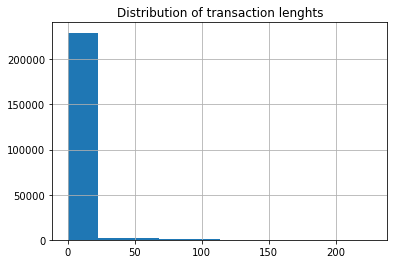

In [17]:
print(diff.sort_values('seconds', ascending=False).head())
diff['seconds'].hist()
plt.title('Distribution of transaction lenghts')

                 seconds  counts
trans_id_2                      
2021-07-27_40   0.000000       5
2021-05-11_103  0.000000       5
2022-01-31_75   0.000000       5
2020-11-28_17   8.234130       5
2020-11-28_14   0.000000       5
2020-11-27_99   4.858878       5
2022-01-31_65   0.000000       5
2021-09-02_75   0.000000       5
2021-06-09_11   0.000000       5
2022-01-31_56   0.000000       5


Text(0.5, 1.0, 'Distribution of transaction sizes')

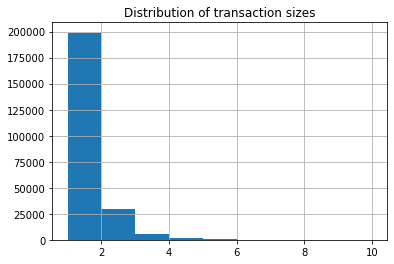

In [18]:
print(diff.sort_values('counts', ascending=False).head(10))
diff['counts'].hist(bins=[1,2,3,4,5,6,7,8,9,10])
plt.title('Distribution of transaction sizes')

In [19]:
# remove outlying transaction ids. 
# replace them with index id. 
df=c_co_out.copy()
df.loc[df[df['trans_id_2'].isin(diff[diff['counts']>6].index)].index ,\
       ['trans_id_2']]=df[df['trans_id_2'].isin(diff[diff['counts']>6].index)].index

In [20]:
len(set(list(df['trans_id_2'])))

235495

In [21]:
len(set(list(c_co_out['trans_id_2'])))

235495

In [22]:
# plots after removing outliers
diff2=df.groupby('trans_id_2')['seconds'].agg(np.ptp).to_frame('time_window')
diff2['counts_2']=df.groupby('trans_id_2').size()


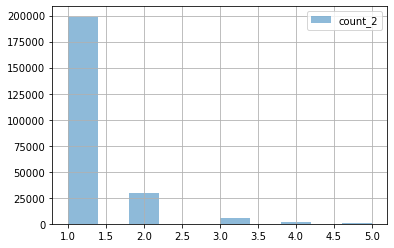

In [23]:
diff2['counts_2'].hist(alpha=0.5 ,label='count_2')

plt.legend()
plt.show()

<AxesSubplot:>

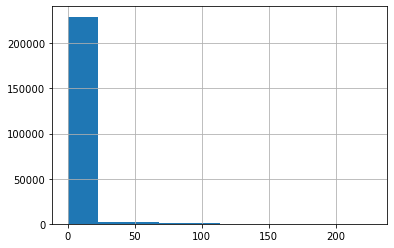

In [24]:
# time width of the transactions
diff2['time_window'].hist()

<AxesSubplot:>

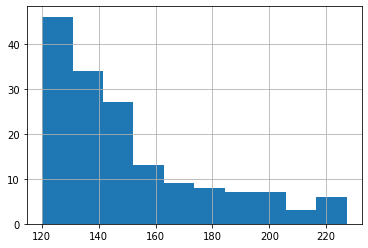

In [25]:
diff2[diff2['time_window']>120]['time_window'].hist()

In [26]:
diff2.shape

(235495, 2)

In [27]:
# if we had used only timestamp without clustering in time...
df.groupby(by=['NextOwnerId','OwnerSince']).size().sort_values(ascending=False).shape

(247990,)

In [28]:
diff2.shape[0]- df.groupby(by=['NextOwnerId','OwnerSince']).size().sort_values(ascending=False).shape[0]

-12495

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

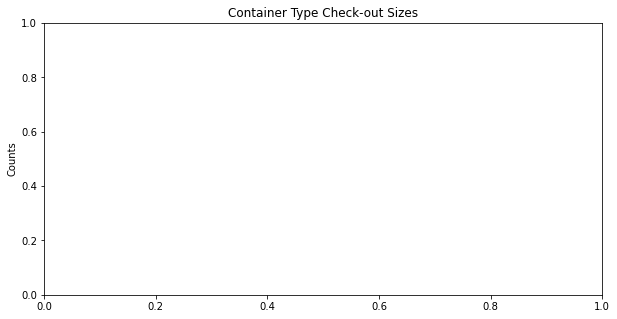

In [29]:
# plot how often which container types are check-out. 
# 
plt.figure(figsize=(10,5))
plt.title('Container Type Check-out Sizes')
plt.ylabel('Counts')

df.groupby(df['container_type_id'].astype(int)).size().plot.bar()
#plt.hist(df['container_type_id'], bins=11) # convert to hours
plt.show()

In [ ]:
df[df['trans_id_2'].isna()]

In [ ]:
df.tail(5)

In [ ]:
df['trans_id_2'].is_unique

## Association

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
basket= (df.groupby(['trans_id_2', 'container_type_id']).size().unstack().reset_index().fillna(0).set_index('trans_id_2'))


In [ ]:
basket.head()

In [ ]:
# we change the matrix into 1: borrowed or 0: not borrowed. 
# In other words, we do not care about multiple borrowings of the same container types. 
# The question is here: is there any interaction between borrowings of different container types? 
#That refers exactly the associiation analysis. 
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

# Encoding the datasets
basket_encoded = basket.applymap(hot_encode)
basket = basket_encoded

In [ ]:
basket

In [ ]:
set(list(basket.sum(axis=1)))

In [ ]:
# The number of items in transactions.
# People usually get only one container.

a=basket.sum(axis=1)

unique, counts = np.unique(a, return_counts=True)
print('Total number of transactions:',sum(counts))
print('The number of container types that are borrowed:')
dict(zip(unique, counts))

In [ ]:
# create frequent itemsets
itemsets = apriori(basket, min_support=0.0001, use_colnames=True)

# and convert into rules
rules = association_rules(itemsets, metric='lift', min_threshold=1)
#rules.sort_values(by=['lift'], ascending=False).head(6)
rules.drop(columns=[ 'conviction', 'leverage']).sort_values(by=['lift'], ascending=False)
#

see the link for the definitions above in the dataframe (support, lift, etc.)
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/ <br>


## Conclusion
Since the transactions usually contain only one item, supports are low. 
The most significant rule is the 2nd rule as sorted by 'Lift' measurement.
However, its support is one of the lowest.
Therefore, I conclude further investigation in association analysis is not needed in the lights of support and Lift measurements.
Furthermore, further analysis (demand prediction, optimization of the rebalancing, etc.) can focus on container type 1. 




In [ ]:
## Save the dataframes for further analysis
#c_co_in.to_csv('c_co_in.csv')
rules.to_csv('association_rules.csv')

